## Import necessary modules

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

import warnings
warnings.filterwarnings('ignore')

## Data Exploration

### Load datasets into a single DataFrame

In [ ]:
# Specify the columns to read
columns_to_read = ['STATE', 'STATENAME', 'LATITUDE', 'LONGITUD', 'LGT_COND', 'LGT_CONDNAME',
                   'WEATHER', 'WEATHERNAME', 'FATALS', 'MONTHNAME', 'DAY', 'DAY_WEEKNAME',
                   'HOUR', 'HOURNAME', 'MINUTE']

# Get the list of CSV files in the directory
datasets = glob.glob("*.csv")

# Concatenate all CSV files into a single DataFrame
dfs = []
for file in datasets:
    try:
        df = pd.read_csv(file, usecols=columns_to_read, encoding='latin-1')
        # Rename the column from 'LONGITUD' to 'LONGITUDE'
        df.rename(columns={'LONGITUD': 'LONGITUDE'}, inplace=True)
        dfs.append(df)
    except UnicodeDecodeError:
        print(f"Error reading file: {file}")

# Concatenate DataFrames
df = pd.concat(dfs, ignore_index=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177409 entries, 0 to 177408
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   STATE         177409 non-null  int64  
 1   STATENAME     177409 non-null  object 
 2   DAY           177409 non-null  int64  
 3   MONTHNAME     177409 non-null  object 
 4   DAY_WEEKNAME  177409 non-null  object 
 5   HOUR          177409 non-null  int64  
 6   HOURNAME      177409 non-null  object 
 7   MINUTE        177409 non-null  int64  
 8   LATITUDE      177409 non-null  float64
 9   LONGITUDE     177409 non-null  float64
 10  LGT_COND      177409 non-null  int64  
 11  LGT_CONDNAME  177409 non-null  object 
 12  WEATHER       177409 non-null  int64  
 13  WEATHERNAME   177409 non-null  object 
 14  FATALS        177409 non-null  int64  
dtypes: float64(2), int64(7), object(6)
memory usage: 20.3+ MB


### Checking accuracy of encoded values

In [ ]:
# Define a dictionary to map numerical codes to their corresponding descriptions
lgt_cond_mapping = {
    1: 'Daylight',
    2: 'Dark - Not Lighted',
    3: 'Dark - Lighted',
    4: 'Dawn',
    5: 'Dusk',
    6: 'Dark - Unknown Lighting',
    7: 'Other',
    8: 'Not Reported',
    9: 'Unknown'  # Combine both 'Reported as Unknown' and 'Unknown'
}

# Map 'LGT_COND' column using the lgt_cond_mapping dictionary
df['LGT_COND_DESCRIPTION'] = df['LGT_COND'].map(lgt_cond_mapping)

# Check if either 'Reported as Unknown' or 'Unknown' matches
if (((df['LGT_CONDNAME'] == 'Reported as Unknown') | (df['LGT_CONDNAME'] == 'Unknown')) &
     (df['LGT_COND_DESCRIPTION'] == 'Unknown')).any():
    print('Encoding of LGT_CONDNAME into LGT_COND is accurate.')
else:
    print('Encoding of LGT_CONDNAME into LGT_COND is inaccurate.')

Encoding of LGT_CONDNAME into LGT_COND is accurate.


In [ ]:
# Define weather mapping dictionary
weather_mapping = {
    1: 'Clear',
    2: 'Rain',
    3: 'Sleet or Hail',
    4: 'Snow',
    5: 'Fog, Smog, Smoke',
    6: 'Severe Crosswinds',
    7: 'Blowing Sand, Soil, Dirt',
    8: 'Other',
    10: 'Cloudy',
    11: 'Blowing Snow',
    12: 'Freezing Rain or Drizzle',
    98: 'Not Reported',
    99: 'Unknown'  # Combine both 'Reported as Unknown' and 'Unknown'
}

# Map WEATHER column using the weather_mapping dictionary
df['WEATHER_DESCRIPTION'] = df['WEATHER'].map(weather_mapping)

# Check if 'WEATHERNAME' matches 'WEATHER_DESCRIPTION' for 'Reported as Unknown' or 'Unknown'
if (((df['WEATHERNAME'] == 'Reported as Unknown') | (df['WEATHERNAME'] == 'Unknown')) &
     (df['WEATHER_DESCRIPTION'] == 'Unknown')).any():
    print('Encoding of WEATHERNAME into WEATHER is accurate.')
else:
    print('Encoding of WEATHERNAME into WEATHER is inaccurate.')

Encoding of WEATHERNAME into WEATHER is accurate.


### Checking counts

In [ ]:
# Considering the possibility of deleting certain data points
weather_counts = df['WEATHERNAME'].value_counts()
print(weather_counts)
print()

lgt_cond_counts = df['LGT_CONDNAME'].value_counts()
print(lgt_cond_counts)



Clear                       122993
Cloudy                       24697
Rain                         13089
Not Reported                 11172
Fog, Smog, Smoke              2022
Snow                          1631
Reported as Unknown            678
Severe Crosswinds              288
Sleet or Hail                  222
Other                          169
Freezing Rain or Drizzle       145
Blowing Snow                   134
Unknown                        118
Blowing Sand, Soil, Dirt        51
Name: WEATHERNAME, dtype: int64

Daylight                   82416
Dark - Not Lighted         48472
Dark - Lighted             36289
Dusk                        4248
Dawn                        3352
Dark - Unknown Lighting     1500
Reported as Unknown          623
Not Reported                 286
Unknown                      133
Other                         90
Name: LGT_CONDNAME, dtype: int64


In [ ]:
# Define the conditions
condition_1 = df['WEATHERNAME'].isin(['Not Reported', 'Reported as Unknown', 'Other', 'Unknown'])
condition_2 = df['LGT_CONDNAME'].isin(['Dark - Unknown Lighting', 'Reported as Unknown', 'Not Reported', 'Other', 'Unknown'])

# Count rows satisfying each condition
condition_1_count = condition_1.sum()
condition_2_count = condition_2.sum()

# Count rows that satisfy either condition
either_condition_count = (condition_1 | condition_2).sum()

print('Rows satisfying Condition 1:', condition_1_count)
print('Rows satisfying Condition 2:', condition_2_count)
print('Rows satisfying either condition:', either_condition_count)

Rows satisfying Condition 1: 12137
Rows satisfying Condition 2: 2632
Rows satisfying either condition: 13725


## Data Cleaning

### Missing values

In [ ]:
df.isnull().sum()

STATE                   0
STATENAME               0
DAY                     0
MONTHNAME               0
DAY_WEEKNAME            0
HOUR                    0
HOURNAME                0
MINUTE                  0
LATITUDE                0
LONGITUDE               0
LGT_COND                0
LGT_CONDNAME            0
WEATHER                 0
WEATHERNAME             0
FATALS                  0
LGT_COND_DESCRIPTION    0
WEATHER_DESCRIPTION     0
dtype: int64

In [ ]:
# Create a mask to select rows that do not satisfy either condition above
mask = ~(condition_1 | condition_2)

# Filter the DataFrame to keep only rows that do not satisfy either condition
df = df[mask]

df

,STATE,STATENAME,DAY,MONTHNAME,DAY_WEEKNAME,HOUR,HOURNAME,MINUTE,LATITUDE,LONGITUDE,LGT_COND,LGT_CONDNAME,WEATHER,WEATHERNAME,FATALS,LGT_COND_DESCRIPTION,WEATHER_DESCRIPTION
0,1,Alabama,19,February,Sunday,23,11:00pm-11:59pm,35,33.335661,-87.007094,2,Dark - Not Lighted,1,Clear,1,Dark - Not Lighted,Clear
1,1,Alabama,14,February,Tuesday,14,2:00pm-2:59pm,59,34.661528,-86.786853,1,Daylight,1,Clear,1,Daylight,Clear
2,1,Alabama,31,January,Tuesday,20,8:00pm-8:59pm,31,32.366519,-86.145281,2,Dark - Not Lighted,1,Clear,1,Dark - Not Lighted,Clear
3,1,Alabama,1,January,Sunday,16,4:00pm-4:59pm,55,33.510175,-86.894003,3,Dark - Lighted,2,Rain,1,Dark - Lighted,Rain
4,1,Alabama,1,January,Sunday,20,8:00pm-8:59pm,0,31.947236,-86.556778,2,Dark - Not Lighted,2,Rain,1,Dark - Not Lighted,Rain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177404,56,Wyoming,12,December,Saturday,16,4:00pm-4:59pm,36,41.211981,-105.123781,2,Dark - Not Lighted,4,Snow,1,Dark - Not Lighted,Snow
177405,56,Wyoming,18,December,Friday,18,6:00pm-6:59pm,6,42.814131,-110.957272,2,Dark - Not Lighted,1,Clear,2,Dark - Not Lighted,Clear
177406,56,Wyoming,11,December,Friday,17,5:00pm-5:59pm,30,42.993033,-108.406514,2,Dark - Not Lighted,4,Snow,1,Dark - Not Lighted,Snow
177407,56,Wyoming,15,December,Tuesday,20,8:00pm-8:59pm,21,41.138478,-104.787133,2,Dark - Not Lighted,1,Clear,1,Dark - Not Lighted,Clear


### Duplicates

In [ ]:
# Check for duplicate rows where all columns match
duplicate_rows = df[df.duplicated(keep=False)]

# Check if there are any duplicate rows
if not duplicate_rows.empty:
    print('Duplicate rows found:')
    print()
    print(duplicate_rows)
    print()

    # Delete duplicate rows
    df.drop_duplicates(keep=False, inplace=True)

    print('Duplicate rows deleted.')
else:
    print('No duplicate rows found.')

Duplicate rows found:

        STATE   STATENAME  DAY MONTHNAME DAY_WEEKNAME  HOUR       HOURNAME  \
67916      48       Texas   14     March       Sunday     0  0:00am-0:59am   
67919      48       Texas   14     March       Sunday     0  0:00am-0:59am   
98479      40    Oklahoma    7  December       Friday    18  6:00pm-6:59pm   
98480      40    Oklahoma    7  December       Friday    18  6:00pm-6:59pm   
112961      6  California    4    August       Sunday    21  9:00pm-9:59pm   
113150      6  California    4    August       Sunday    21  9:00pm-9:59pm   
119711     17    Illinois   25      July     Thursday     3  3:00am-3:59am   
119763     17    Illinois   25      July     Thursday     3  3:00am-3:59am   
120442     18     Indiana   27     April     Saturday     8  8:00am-8:59am   
120447     18     Indiana   27     April     Saturday     8  8:00am-8:59am   

        MINUTE   LATITUDE   LONGITUDE  LGT_COND        LGT_CONDNAME  WEATHER  \
67916       35  32.772017  -95.035517 

### Unwanted columns

In [ ]:
# List of columns to delete
columns_to_delete = ['MONTHNAME', 'DAY', 'DAY_WEEKNAME', 'HOURNAME',
                     'MINUTE', 'LGT_COND_DESCRIPTION', 'WEATHER_DESCRIPTION']

# Drop the specified columns and reset the row indices
df = df.drop(columns=columns_to_delete)

df

,STATE,STATENAME,HOUR,LATITUDE,LONGITUDE,LGT_COND,LGT_CONDNAME,WEATHER,WEATHERNAME,FATALS
0,1,Alabama,23,33.335661,-87.007094,2,Dark - Not Lighted,1,Clear,1
1,1,Alabama,14,34.661528,-86.786853,1,Daylight,1,Clear,1
2,1,Alabama,20,32.366519,-86.145281,2,Dark - Not Lighted,1,Clear,1
3,1,Alabama,16,33.510175,-86.894003,3,Dark - Lighted,2,Rain,1
4,1,Alabama,20,31.947236,-86.556778,2,Dark - Not Lighted,2,Rain,1
...,...,...,...,...,...,...,...,...,...,...
177404,56,Wyoming,16,41.211981,-105.123781,2,Dark - Not Lighted,4,Snow,1
177405,56,Wyoming,18,42.814131,-110.957272,2,Dark - Not Lighted,1,Clear,2
177406,56,Wyoming,17,42.993033,-108.406514,2,Dark - Not Lighted,4,Snow,1
177407,56,Wyoming,20,41.138478,-104.787133,2,Dark - Not Lighted,1,Clear,1


### Outliers

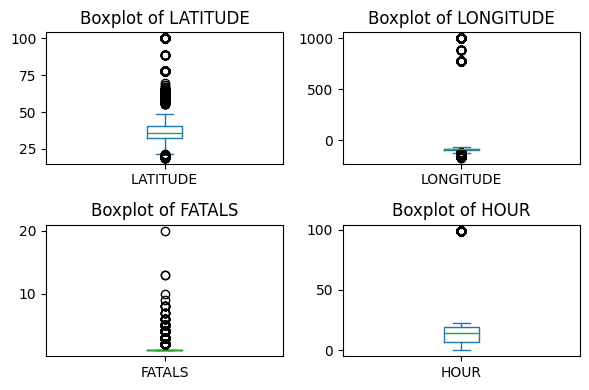

Summary Statistics of Numerical Columns:
            LATITUDE      LONGITUDE         FATALS           HOUR
count  163674.000000  163674.000000  163674.000000  163674.000000
mean       36.460595     -89.947934       1.086672      13.472005
std         6.076010      57.172713       0.353167       9.448836
min        19.035111    -170.514936       1.000000       0.000000
25%        32.790927     -98.357303       1.000000       7.000000
50%        35.755033     -88.128903       1.000000      14.000000
75%        40.468333     -81.940803       1.000000      19.000000
max        99.999900     999.999900      20.000000      99.000000

Potential outliers in LATITUDE:
         LATITUDE
374     99.999900
864     64.826461
865     62.400528
866     61.523142
867     61.150592
...           ...
171372  77.777700
171416  77.777700
172237  99.999900
174487  77.777700
176018  77.777700

[968 rows x 1 columns]

Potential outliers in LONGITUDE:
         LONGITUDE
374     999.999900
864    -147.751478
8

In [ ]:
# Define numerical columns to investigate
numerical_columns = ['LATITUDE', 'LONGITUDE', 'FATALS', 'HOUR']

# Plot separate boxplots for each numerical column
plt.figure(figsize=(6, 4))

for i, column in enumerate(numerical_columns, start=1):
    plt.subplot(2, 2, i)
    df[column].plot(kind='box')
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

# Summary statistics
summary_statistics = df[numerical_columns].describe()
print('Summary Statistics of Numerical Columns:')
print(summary_statistics)
print()

# Identify potential outliers based on IQR
Q1 = summary_statistics.loc['25%']
Q3 = summary_statistics.loc['75%']
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Print potential outliers for each numerical column
for column in numerical_columns:
    outliers = df[(df[column] < lower_bound[column]) | (df[column] > upper_bound[column])]
    if not outliers.empty:
        print(f'Potential outliers in {column}:')
        print(outliers[[column]])
    else:
        print(f'No potential outliers found in {column}.')
    print()


In [ ]:
# Delete outliers in HOUR column
df = df[df['HOUR'].between(0, 24)]

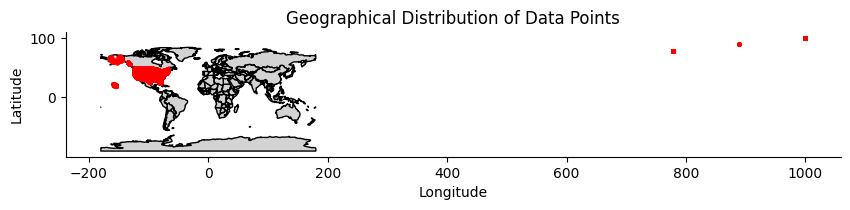

In [ ]:
# Load the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a GeoDataFrame from your DataFrame with longitude and latitude
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.LONGITUDE, df.LATITUDE))

# Plot the world map
world.plot(figsize=(10, 8), color='lightgrey', edgecolor='black')

# Plot the data points on top of the map
gdf.plot(ax=plt.gca(), color='red', markersize=5, alpha=1)

# Customize plot
plt.title('Geographical Distribution of Data Points')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show the map
plt.show()

In [ ]:
# Delete outliers in LONGITUDE and LATITUDE columns
# Goal: To correspond with actual USA LONG & LAT

df = df[(df['LONGITUDE'] <= 0) &
        (df['LATITUDE'] >= 18) & (df['LATITUDE'] <= 75)]

## Feature Engineering

### Time of day

In [ ]:
# Function to categorize hour into time of day
def categorize_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 20:
        return 'Evening'
    else:
        return 'Night'

# Apply the function to create a new column
df['TIME_OF_DAY'] = df['HOUR'].apply(categorize_time_of_day)

df[['HOUR', 'TIME_OF_DAY']].tail(6)

,HOUR,TIME_OF_DAY
177403,11,Morning
177404,16,Afternoon
177405,18,Evening
177406,17,Evening
177407,20,Night
177408,9,Morning


### NHTSA Regions

In [ ]:
# Define NHTSA regions

nhtsa_regions = {
    'Region 1':  ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 'Vermont'],
    'Region 2':  ['New Jersey', 'New York', 'Puerto Rico', 'Virgin Islands'],
    'Region 3':  ['Delaware', 'District of Columbia', 'Maryland', 'Pennsylvania', 'Virginia', 'West Virginia'],
    'Region 4':  ['Alabama', 'Florida', 'Georgia', 'Kentucky', 'Mississippi', 'North Carolina', 'South Carolina', 'Tennessee'],
    'Region 5':  ['Illinois', 'Indiana', 'Michigan', 'Minnesota', 'Ohio', 'Wisconsin'],
    'Region 6':  ['Arkansas', 'Louisiana', 'New Mexico', 'Oklahoma', 'Texas'],
    'Region 7':  ['Iowa', 'Kansas', 'Missouri', 'Nebraska'],
    'Region 8':  ['Colorado', 'Montana', 'North Dakota', 'South Dakota', 'Utah', 'Wyoming'],
    'Region 9':  ['Arizona', 'California', 'Hawaii', 'Nevada'],
    'Region 10': ['Alaska', 'Idaho', 'Oregon', 'Washington']
}

# Create a reverse mapping from state name to region number
state_to_region = {state: region_number for region_number, states in
                   enumerate(nhtsa_regions, 1) for state in nhtsa_regions[states]}

# Create a new column 'NHTSA_Region' based on the mapping
df['NHTSA_Region'] = df['STATENAME'].map(state_to_region)

In [ ]:
# Reset indices
df.reset_index(inplace=True, drop=True)
df


,STATE,STATENAME,HOUR,LATITUDE,LONGITUDE,LGT_COND,LGT_CONDNAME,WEATHER,WEATHERNAME,FATALS,TIME_OF_DAY,NHTSA_Region
0,1,Alabama,23,33.335661,-87.007094,2,Dark - Not Lighted,1,Clear,1,Night,4
1,1,Alabama,14,34.661528,-86.786853,1,Daylight,1,Clear,1,Afternoon,4
2,1,Alabama,20,32.366519,-86.145281,2,Dark - Not Lighted,1,Clear,1,Night,4
3,1,Alabama,16,33.510175,-86.894003,3,Dark - Lighted,2,Rain,1,Afternoon,4
4,1,Alabama,20,31.947236,-86.556778,2,Dark - Not Lighted,2,Rain,1,Night,4
...,...,...,...,...,...,...,...,...,...,...,...,...
162273,56,Wyoming,16,41.211981,-105.123781,2,Dark - Not Lighted,4,Snow,1,Afternoon,8
162274,56,Wyoming,18,42.814131,-110.957272,2,Dark - Not Lighted,1,Clear,2,Evening,8
162275,56,Wyoming,17,42.993033,-108.406514,2,Dark - Not Lighted,4,Snow,1,Evening,8
162276,56,Wyoming,20,41.138478,-104.787133,2,Dark - Not Lighted,1,Clear,1,Night,8


## Data Visualization

### Fatalities by Hour of Day

Text(0.5, 1.0, 'Fatalities by Hour of the Day')

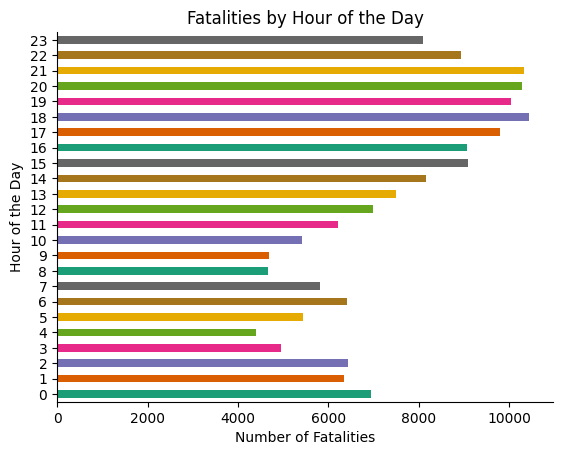

In [ ]:
# Group fatalities by hour of the day
fatalities_by_hour = df.groupby('HOUR')['FATALS'].sum()

# Plotting
fatalities_by_hour.plot(kind='barh', color=sns.color_palette('Dark2'))

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xlabel('Number of Fatalities')
plt.ylabel('Hour of the Day')
plt.title('Fatalities by Hour of the Day')

### Fatalities by State

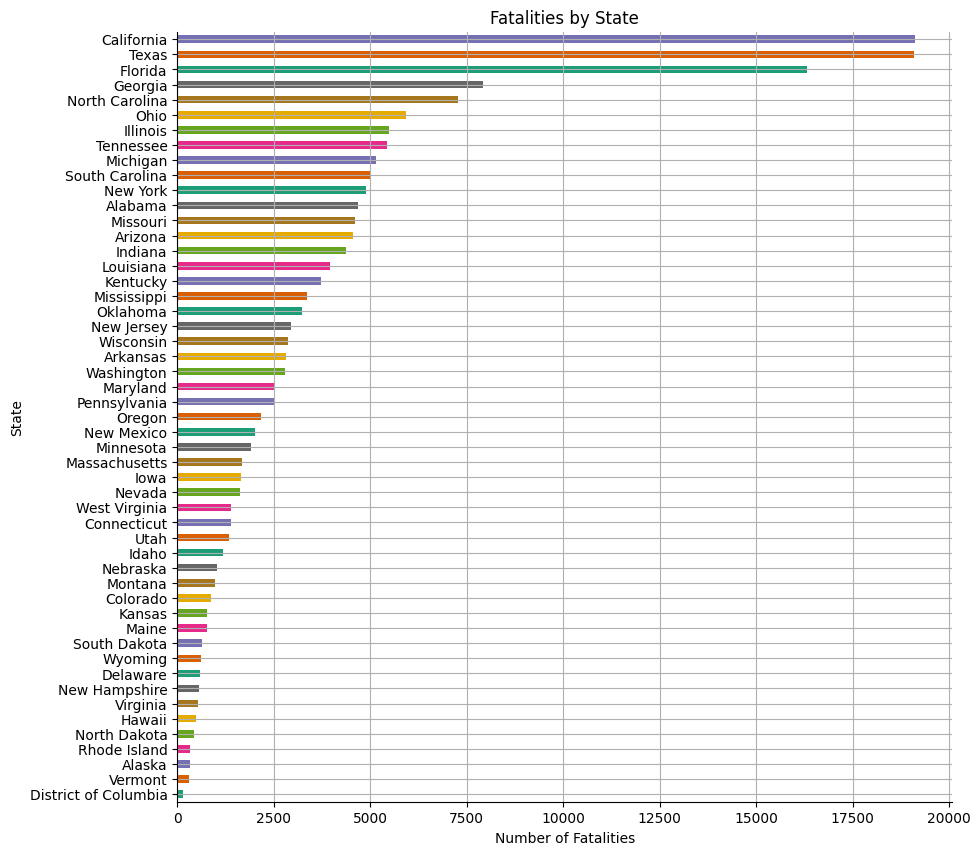

In [ ]:
plt.figure(figsize=(10, 10))
fatalities_by_state = df.groupby('STATENAME')['FATALS'].sum()
fatalities_by_state_sorted = fatalities_by_state.sort_values(ascending=True)
fatalities_by_state_sorted.plot(kind='barh', color=sns.color_palette('Dark2'))

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('Number of Fatalities')
plt.ylabel('State')
plt.grid()
plt.title('Fatalities by State')

plt.show()

### Weather Conditions by NHTSA Region

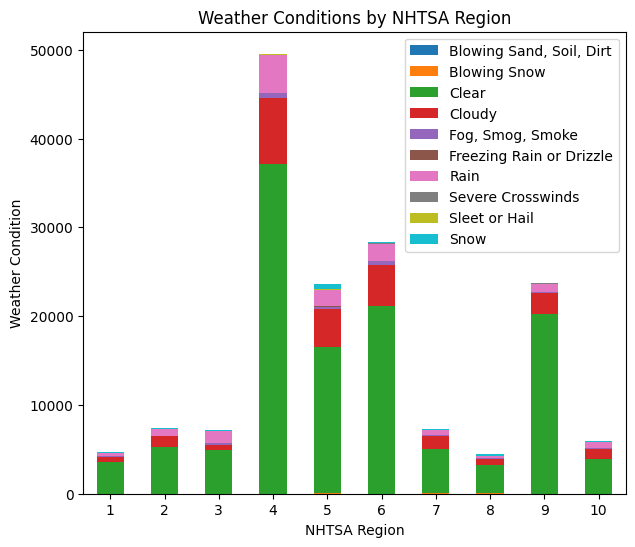

In [ ]:
df.groupby('NHTSA_Region')['WEATHERNAME'].value_counts().unstack().plot.bar(stacked=True)

plt.xlabel('NHTSA Region')
plt.ylabel('Weather Condition')
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.title('Weather Conditions by NHTSA Region')

plt.gcf().set_size_inches(7, 6)


### Light Conditions by NHTSA Region

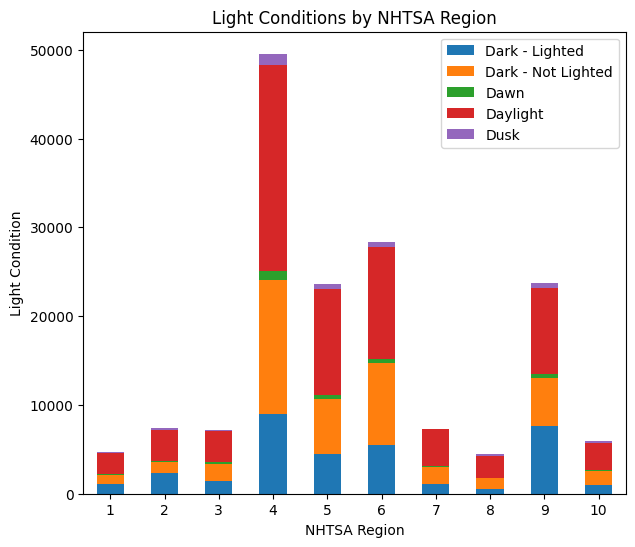

In [ ]:
df.groupby('NHTSA_Region')['LGT_CONDNAME'].value_counts().unstack().plot.bar(stacked=True)

plt.xlabel('NHTSA Region')
plt.ylabel('Light Condition')
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.title('Light Conditions by NHTSA Region')

plt.gcf().set_size_inches(7, 6)


### Fatalities by Lighting Condition

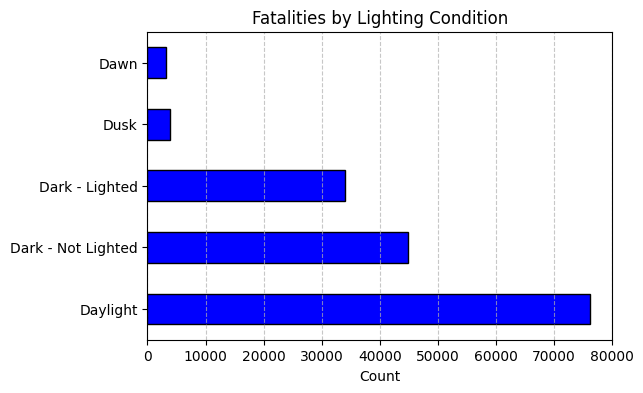

In [ ]:
df['LGT_CONDNAME'].value_counts().plot.barh(color='b', edgecolor='black', figsize=(6, 4))
plt.xlabel('Count')
plt.title('Fatalities by Lighting Condition')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


### Fatalities by Weather Pattern

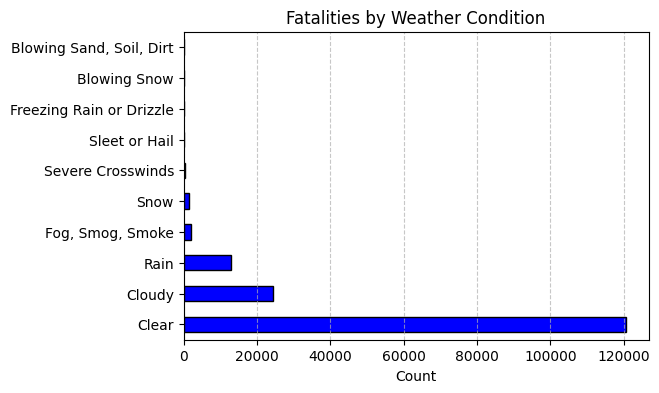

In [ ]:
df['WEATHERNAME'].value_counts().plot.barh(color='b', edgecolor='black', figsize=(6, 4))
plt.xlabel('Count')
plt.title('Fatalities by Weather Condition')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


### Latitude vs. Longitude

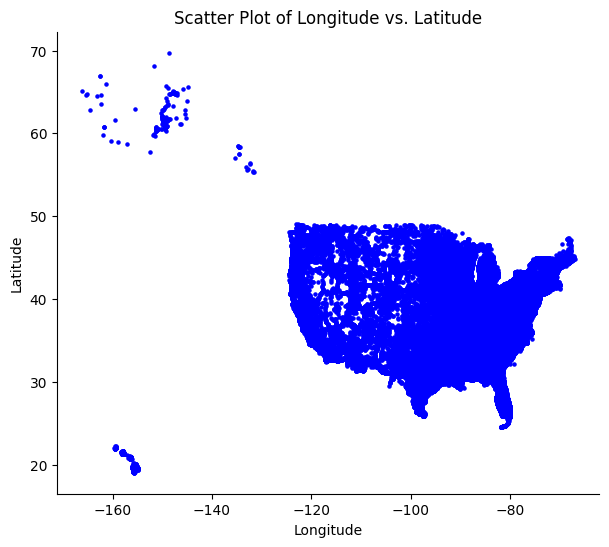

In [ ]:
plt.figure(figsize=(7, 6))
plt.scatter(df['LONGITUDE'], df['LATITUDE'], s=5, alpha=1, color='b')

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Set labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter Plot of Longitude vs. Latitude')
plt.show()

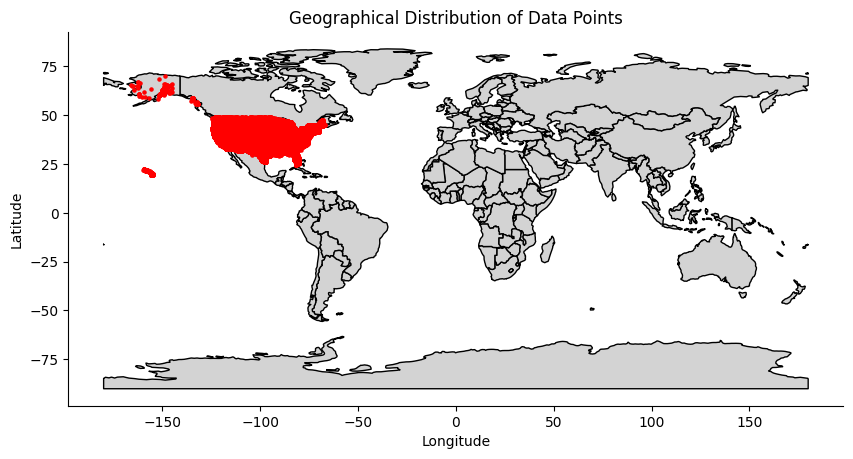

In [ ]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.LONGITUDE, df.LATITUDE))
world.plot(figsize=(10, 8), color='lightgrey', edgecolor='black')

gdf.plot(ax=plt.gca(), color='red', markersize=5, alpha=1)

plt.title('Geographical Distribution of Data Points')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()


### Light Condition vs. Weather Condition

<Axes: >

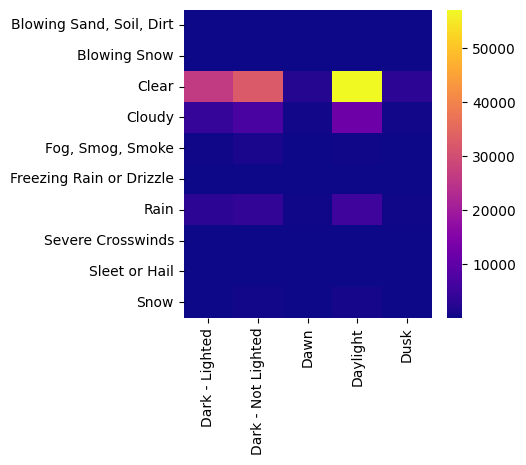

In [ ]:
plt.subplots(figsize=(4, 4))
df_2dhist = pd.DataFrame({
    x_label: grp['WEATHERNAME'].value_counts()
    for x_label, grp in df.groupby('LGT_CONDNAME')
})
sns.heatmap(df_2dhist, cmap='plasma')

### Geospatial Clustering

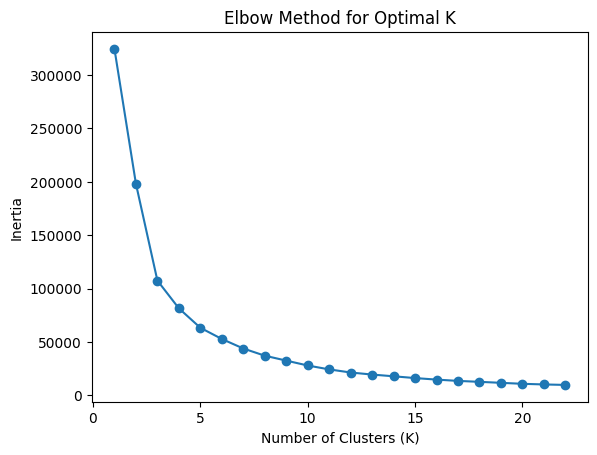

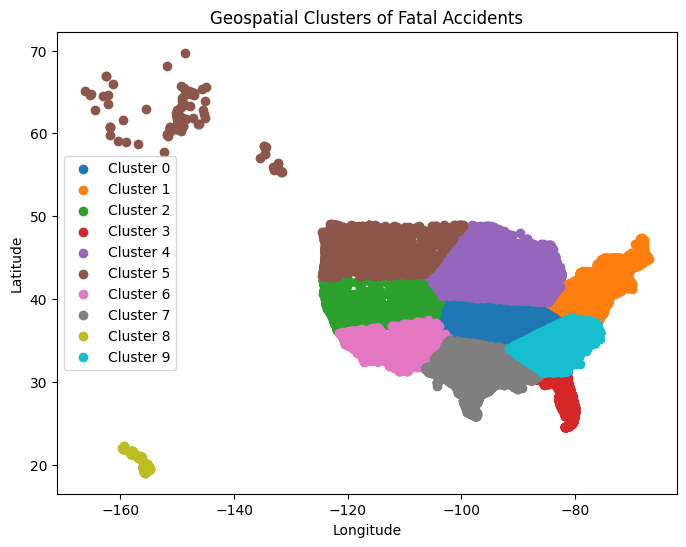

In [ ]:
from sklearn.cluster import KMeans

# Select latitude and longitude columns
coordinates = df[['LATITUDE', 'LONGITUDE']]

# Standardize data
coordinates_standardized = (coordinates - coordinates.mean()) / coordinates.std()

# Optimal number of clusters (K) - the elbow method
inertia = []
for k in range(1, 23):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(coordinates_standardized)
    inertia.append(kmeans.inertia_)

# Plot the elbow method
plt.plot(range(1, 23), inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()

# I will choose K=10
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(coordinates_standardized)

# Add cluster labels to the DataFrame
df['CLUSTER'] = kmeans.labels_

# Visualize clusters on a map
plt.figure(figsize=(8, 6))
for cluster_label in range(10):
    cluster_points = coordinates[df['CLUSTER'] == cluster_label]
    plt.scatter(cluster_points['LONGITUDE'], cluster_points['LATITUDE'], label=f'Cluster {cluster_label}')
plt.title('Geospatial Clusters of Fatal Accidents')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()